In [1]:
# ディープラーニングモデルの作成

import numpy as np

# setting the seed allows for reproducible results
np.random.seed(123)

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Flatten, Dense
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K

import pandas as pd

class Model:
    def __init__(self):
        self.data = None
        self.model = None
        
    def __build_model(self, input_shape, outputs):
        '''
        Builds and returns the Deep Neural Network that will compute the allocation ratios
        that optimize the Sharpe Ratio of the portfolio
        
        inputs: input_shape - tuple of the input shape, outputs - the number of assets
        returns: a Deep Neural Network model
        '''
        model = Sequential([
            LSTM(64, input_shape=input_shape),
            Flatten(),
            Dense(outputs, activation='softmax')
        ])

        def sharpe_loss(_, y_pred):
            # make all time-series start at 1
            data = tf.divide(self.data, self.data[0])  
            
            # value of the portfolio after allocations applied
            portfolio_values = tf.reduce_sum(tf.multiply(data, y_pred), axis=1) 
            
            portfolio_returns = (portfolio_values[1:] - portfolio_values[:-1]) / portfolio_values[:-1]  # % change formula

            sharpe = K.mean(portfolio_returns) / K.std(portfolio_returns)
            
            # since we want to maximize Sharpe, while gradient descent minimizes the loss, 
            #   we can negate Sharpe (the min of a negated function is its max)
            return -sharpe
        
        model.compile(loss=sharpe_loss, optimizer='adam')
        return model
    
    def get_allocations(self, data: pd.DataFrame):
        '''
        Computes and returns the allocation ratios that optimize the Sharpe over the given data
        
        input: data - DataFrame of historical closing prices of various assets
        
        return: the allocations ratios for each of the given assets
        '''
        
        # data with returns
        data_w_ret = np.concatenate([ data.values[1:], data.pct_change().values[1:] ], axis=1)
        
        data = data.iloc[1:]
        self.data = tf.cast(tf.constant(data), float)
        
        if self.model is None:
            self.model = self.__build_model(data_w_ret.shape, len(data.columns))
        
        fit_predict_data = data_w_ret[np.newaxis,:]        
        self.model.fit(fit_predict_data, np.zeros((1, len(data.columns))), epochs=20, shuffle=False)
        return self.model.predict(fit_predict_data)[0]

In [13]:
# データのロード

import pandas_datareader.data as pdr
import datetime

start = datetime.datetime(2018, 1, 1)
end = datetime.datetime(2020, 12, 31)

# ウェルスナビで使用している6銘柄
pd_data = pdr.DataReader(['VTI','VEA','VWO','AGG','GLD','IYR'], 'yahoo', start, end)
data_close = pd_data['Close']
 
data_close.head() 

Symbols,VTI,VEA,VWO,AGG,GLD,IYR
Date,,,,,,
2018-01-02,138.220001,45.250000,46.700001,109.169998,125.150002,80.599998
2018-01-03,139.020004,45.529999,47.150002,109.180000,124.820000,80.470001
2018-01-04,139.550003,45.939999,47.439999,109.110001,125.459999,79.209999
2018-01-05,140.369995,46.160000,47.860001,109.040001,125.330002,79.290001
2018-01-08,140.690002,46.139999,47.869999,109.010002,125.309998,79.739998


In [14]:
# モデルを用いて資産配分を計算
model = Model()
alc = model.get_allocations(data_close)

Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: -0.0315
Epoch 2/20
1/1 [==============================] - 0s 340ms/step - loss: -0.0322
Epoch 3/20
1/1 [==============================] - 0s 300ms/step - loss: -0.0329
Epoch 4/20
1/1 [==============================] - 0s 290ms/step - loss: -0.0335
Epoch 5/20
1/1 [==============================] - 0s 292ms/step - loss: -0.0342
Epoch 6/20
1/1 [==============================] - 0s 313ms/step - loss: -0.0348
Epoch 7/20
1/1 [==============================] - 0s 308ms/step - loss: -0.0354
Epoch 8/20
1/1 [==============================] - 0s 325ms/step - loss: -0.0359
Epoch 9/20
1/1 [==============================] - 0s 416ms/step - loss: -0.0364
Epoch 10/20
1/1 [==============================] - 0s 317ms/step - loss: -0.0369
Epoch 11/20
1/1 [==============================] - 0s 284ms/step - loss: -0.0375
Epoch 12/20
1/1 [==============================] - 0s 306ms/step - loss: -0.0382
Epoch 13/20
1/1 [=======================

([<matplotlib.patches.Wedge at 0x7fcc2db32650>,
 [Text(0.6626487652366991, 0.8780071833022086, 'VTI'),
  Text(-0.4720199338159855, 0.9935779698042589, 'VEA'),
  Text(-0.8187327872564353, 0.7346268597535138, 'VWO'),
  Text(-0.9415991890558, -0.5686747463792112, 'AGG'),
  Text(0.5986412697080565, -0.922837271788654, 'GLD'),
  Text(1.0738727659957563, -0.2383218044003185, 'IYR')])

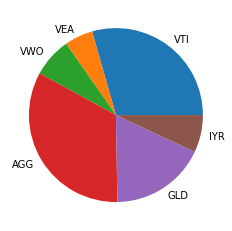

In [15]:
# 算出した比率をプロット

import matplotlib.pyplot as plt

plt.pie(alc, labels=data_close.columns.tolist())